In [149]:
import os
import glob
import random
import pytorch_lightning as pl
import torch
import torch.nn as nn
import skimage.io
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.functional import F

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from pytorch_lightning import loggers as pl_loggers

### Load Tensorboard extension

In [14]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Define Transforms

In [150]:
MEAN_NORMALIZE = torch.tensor([0.485, 0.456, 0.406])
STD_NORMALIZE = torch.tensor([0.229, 0.224, 0.225])

In [151]:
train_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],)
])

validation_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],)
])

test_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],)
])

### Dataset class

In [152]:
class RansomwareDetectionDataset(Dataset):
    def __init__(self, image_paths, class_to_idx, transform=None):
        super().__init__()

        self.image_paths = image_paths
        self.transform = transform
        self.class_to_idx = class_to_idx
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = skimage.io.imread(image_path)

        label = image_path.split("/")[2]
        label = self.class_to_idx[label]

        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

### Create CNN

In [196]:
class BaselineNetwork(pl.LightningModule):
    def __init__(self, number_of_classes, image_size):
        super().__init__()
        
        self.image_size = image_size
        self.final_size = image_size // 2

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(0.2)
        self.linear1 = nn.Linear(in_features=12 * self.final_size * self.final_size, out_features=128)
        self.linear2 = nn.Linear(in_features=128, out_features=64)
        self.linear3 = nn.Linear(in_features=64, out_features=number_of_classes)

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.flatten(start_dim=1)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)

        loss = self.loss(output, y)
        accuracy = (torch.argmax(output, dim=1) == y).sum() / len(y)

        return {
            "loss": loss,
            "accuracy": accuracy
        }

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)

        loss = self.loss(output, y)
        accuracy = (torch.argmax(output,dim=1) == y).sum() / len(y)

        return {
            "loss": loss,
            "accuracy": accuracy
        }

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        avg_accuracy = torch.stack([x["accuracy"] for x in outputs]).mean()

        self.log("Loss/train", avg_loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("Accuracy/train", avg_accuracy, on_epoch=True, prog_bar=True, logger=True)

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        avg_accuracy = torch.stack([x["accuracy"] for x in outputs]).mean()

        self.log("Loss/valid", avg_loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("Accuracy/valid", avg_accuracy, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.0001, momentum=0.9)
        lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.001, step_size_up=2)
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler,
            "monitor": "Loss/valid"
        }


### Create train, validation, test sets

In [154]:
def split(split_dataset):
    train_image_paths, valid_image_paths = train_test_split(split_dataset, train_size=0.7, shuffle=True)

    print(f"Train size: {len(train_image_paths)}")
    print(f"Valid size {len(valid_image_paths)}")

    return train_image_paths, valid_image_paths

In [155]:
def index_to_class(classes):
    idx_to_class = {i:j for i, j in enumerate(classes)}
    class_to_idx = {value:key for key,value in idx_to_class.items()}

    return idx_to_class, class_to_idx

In [185]:
def create_path_datasets(benign_path, ransomware_path):
    random.seed(42)

    benign_paths = list()
    ransomware_paths = list()
    classes = list()

    for path in glob.glob(os.path.join(benign_path, "*")):
        classes.append(path.split("/")[2])
        benign_paths.append(path)

    for path in glob.glob(os.path.join(ransomware_path, "*")):
        classes.append(path.split("/")[2])
        ransomware_paths.append(path)

    random.shuffle(benign_paths)
    random.shuffle(ransomware_paths)

    test_benign_image_paths, train_valid_benign_image_paths = benign_paths[:10], benign_paths[10:]
    test_ransomware_image_paths, train_valid_ransomware_image_paths = ransomware_paths[:10], ransomware_paths[10:]

    test_image_paths = test_benign_image_paths + test_ransomware_image_paths
    train_valid_image_paths = train_valid_benign_image_paths[:500] + train_valid_ransomware_image_paths[:500]

    classes = list(set(classes))

    print(f"Test dataset len: {len(test_image_paths)}")
    print(f"Train validation dataset len: {len(train_valid_image_paths)}")
    print(f"Path example: {train_valid_image_paths[0]}")
    print(f"Class example: {classes[0]}")

    train_image_paths, valid_image_paths = split(train_valid_image_paths)
    idx_to_class, class_to_idx = index_to_class(classes)

    return train_image_paths, valid_image_paths, test_image_paths, idx_to_class, class_to_idx

### Create train validation dataloader

In [186]:
def create_dataloaders(train_dataset, validation_dataset, batch_size=4):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=0)

    print(f"Train dataloader shape {next(iter(train_dataloader))[0].shape}")
    print(f"Validation dataloader shape {next(iter(validation_dataloader))[0].shape}")

    return train_dataloader, validation_dataloader

### Visualitiona of the data loader data

In [187]:
def visualize_data_loader(train_loader, validation_loader):
    rows = 2
    columns = 2
    fig = plt.figure(figsize=(8, 8))

    train_iter = iter(train_loader)
    valid_iter = iter(validation_loader)

    for index in range(0, 4):
        train_image, train_label = next(train_iter)
        valid_image, valid_label = next(valid_iter)
        ax = fig.add_subplot(rows, columns, index + 1)

        x_train = train_image[0] * STD_NORMALIZE[:, None, None] + MEAN_NORMALIZE[:, None, None]
        plt.imshow(x_train.numpy().transpose(1, 2, 0))

        x_valid = valid_image[0] * STD_NORMALIZE[:, None, None] + MEAN_NORMALIZE[:, None, None]
        plt.imshow(x_valid.numpy().transpose(1, 2, 0))

### Eval Model with test dataset

In [188]:
def eval_model(test_dataloader, idx_to_class, model):
    fig = plt.figure(figsize=(25, 7))
    spec = fig.add_gridspec(ncols=10, nrows=2)

    test_iter = iter(test_dataloader)

    y_pred = list()
    y_true = list()

    count = 0
    for row in range(2):
        for col in range(10):
            batch, label = next(test_iter)
            pred = model(batch)
            pred = pred.argmax(dim=1)

            ax = fig.add_subplot(spec[row, col])

            x = batch[0] * STD_NORMALIZE[:, None, None] + MEAN_NORMALIZE[:, None, None]
            ax.imshow(x.numpy().transpose(1, 2, 0))
            ax.set_title(f'label: {idx_to_class[label.item()]}, \n pred: {idx_to_class[pred.item()]}')

            y_pred.append(idx_to_class[pred.item()])
            y_true.append(idx_to_class[label.item()])

            count += 1

    print(classification_report(y_true, y_pred))

## Experiment for gramian angular simulation

In [189]:
benign_gaf_path = "features/images/benign/gaf/branch_misses"
ransomware_gaf_path = "features/images/ransomware/gaf/branch_misses"

print("Benign samples", len(glob.glob(os.path.join(benign_gaf_path, "*"))))
print("Ransomware samples", len(glob.glob(os.path.join(ransomware_gaf_path, "*"))))

Benign samples 1432
Ransomware samples 1432


In [190]:
train_gaf_image_paths, valid_gaf_image_paths, test_gaf_image_paths, gaf_idx_to_class, gaf_class_to_idx = create_path_datasets(benign_gaf_path, ransomware_gaf_path)

train_gaf_dataset = RansomwareDetectionDataset(train_gaf_image_paths, gaf_class_to_idx, transform=train_transformations)
validation_gaf_dataset = RansomwareDetectionDataset(valid_gaf_image_paths, gaf_class_to_idx, transform=validation_transformations)
test_gaf_dataset = RansomwareDetectionDataset(test_gaf_image_paths, gaf_class_to_idx, transform=test_transformation)

print(f"Tensor shape of the image: {train_gaf_dataset[1][0].shape}")
print(f"Label of the image: {gaf_idx_to_class[train_gaf_dataset[1][1]]}")

Test dataset len: 20
Train validation dataset len: 1000
Path example: features/images/benign/gaf/branch_misses/benign_1022.jpg
Class example: ransomware
Train size: 700
Valid size 300
Tensor shape of the image: torch.Size([3, 50, 50])
Label of the image: benign


In [191]:
train_gaf_loader, validation_gaf_loader = create_dataloaders(train_gaf_dataset, validation_gaf_dataset, batch_size=20)

Train dataloader shape torch.Size([20, 3, 50, 50])
Validation dataloader shape torch.Size([20, 3, 50, 50])


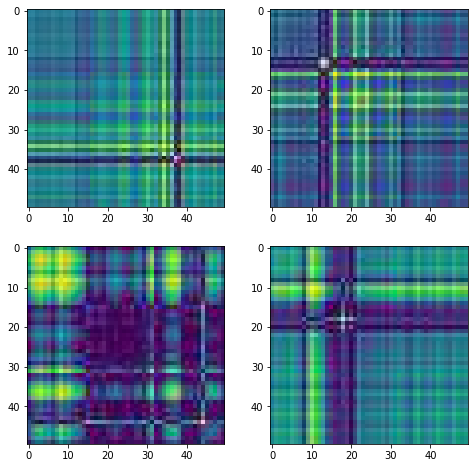

In [192]:
visualize_data_loader(train_gaf_loader, validation_gaf_loader)

In [197]:
gaf_model = BaselineNetwork(number_of_classes=len(gaf_idx_to_class), image_size=50)

In [198]:
checkpoint_callback_gaf = pl.callbacks.ModelCheckpoint(
    dirpath="checkpoints/BM-GAF",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="Loss/valid",
    mode="min"
)
logger_gaf = pl_loggers.TensorBoardLogger("logs/", name="BM-GAF")

trainer_gaf = pl.Trainer(max_epochs=15, log_every_n_steps=1, logger=logger_gaf, callbacks=[checkpoint_callback_gaf])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [199]:
trainer_gaf.fit(gaf_model, train_dataloaders=train_gaf_loader, val_dataloaders=validation_gaf_loader)


  | Name    | Type             | Params
---------------------------------------------
0 | conv1   | Conv2d           | 168   
1 | conv2   | Conv2d           | 660   
2 | maxpool | MaxPool2d        | 0     
3 | dropout | Dropout          | 0     
4 | linear1 | Linear           | 960 K 
5 | linear2 | Linear           | 8.3 K 
6 | linear3 | Linear           | 130   
7 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
969 K     Trainable params
0         Non-trainable params
969 K     Total params
3.877     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 50/50 [00:03<00:00, 13.43it/s, loss=0.693, v_num=12, Loss/valid=0.694, Accuracy/valid=0.477, Loss/train=0.693, Accuracy/train=0.487]

Epoch 0, global step 34: Loss/valid reached 0.69401 (best 0.69401), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/BM-GAF/best-checkpoint-v4.ckpt" as top 1


Epoch 1: 100%|██████████| 50/50 [00:05<00:00,  8.81it/s, loss=0.694, v_num=12, Loss/valid=0.694, Accuracy/valid=0.480, Loss/train=0.693, Accuracy/train=0.501]

Epoch 1, global step 69: Loss/valid was not in top 1


Epoch 2: 100%|██████████| 50/50 [00:03<00:00, 12.97it/s, loss=0.691, v_num=12, Loss/valid=0.694, Accuracy/valid=0.480, Loss/train=0.692, Accuracy/train=0.506]

Epoch 2, global step 104: Loss/valid was not in top 1


Epoch 3: 100%|██████████| 50/50 [00:02<00:00, 17.95it/s, loss=0.692, v_num=12, Loss/valid=0.694, Accuracy/valid=0.480, Loss/train=0.691, Accuracy/train=0.510]

Epoch 3, global step 139: Loss/valid was not in top 1


Epoch 4: 100%|██████████| 50/50 [00:02<00:00, 18.23it/s, loss=0.691, v_num=12, Loss/valid=0.694, Accuracy/valid=0.480, Loss/train=0.692, Accuracy/train=0.507]

Epoch 4, global step 174: Loss/valid was not in top 1


Epoch 5: 100%|██████████| 50/50 [00:03<00:00, 14.69it/s, loss=0.691, v_num=12, Loss/valid=0.694, Accuracy/valid=0.480, Loss/train=0.691, Accuracy/train=0.510]

Epoch 5, global step 209: Loss/valid was not in top 1


Epoch 6: 100%|██████████| 50/50 [00:02<00:00, 18.22it/s, loss=0.692, v_num=12, Loss/valid=0.694, Accuracy/valid=0.480, Loss/train=0.691, Accuracy/train=0.516]

Epoch 6, global step 244: Loss/valid reached 0.69397 (best 0.69397), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/BM-GAF/best-checkpoint-v4.ckpt" as top 1


Epoch 7: 100%|██████████| 50/50 [00:02<00:00, 18.20it/s, loss=0.694, v_num=12, Loss/valid=0.694, Accuracy/valid=0.480, Loss/train=0.691, Accuracy/train=0.514]

Epoch 7, global step 279: Loss/valid was not in top 1


Epoch 8: 100%|██████████| 50/50 [00:02<00:00, 18.90it/s, loss=0.691, v_num=12, Loss/valid=0.694, Accuracy/valid=0.477, Loss/train=0.690, Accuracy/train=0.511]

Epoch 8, global step 314: Loss/valid reached 0.69390 (best 0.69390), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/BM-GAF/best-checkpoint-v4.ckpt" as top 1


Epoch 9: 100%|██████████| 50/50 [00:03<00:00, 14.08it/s, loss=0.69, v_num=12, Loss/valid=0.694, Accuracy/valid=0.480, Loss/train=0.690, Accuracy/train=0.510] 

Epoch 9, global step 349: Loss/valid was not in top 1


Epoch 10: 100%|██████████| 50/50 [00:02<00:00, 18.59it/s, loss=0.69, v_num=12, Loss/valid=0.693, Accuracy/valid=0.510, Loss/train=0.690, Accuracy/train=0.517] 

Epoch 10, global step 384: Loss/valid reached 0.69294 (best 0.69294), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/BM-GAF/best-checkpoint-v4.ckpt" as top 1


Epoch 11: 100%|██████████| 50/50 [00:02<00:00, 18.14it/s, loss=0.689, v_num=12, Loss/valid=0.693, Accuracy/valid=0.537, Loss/train=0.690, Accuracy/train=0.544]

Epoch 11, global step 419: Loss/valid reached 0.69261 (best 0.69261), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/BM-GAF/best-checkpoint-v4.ckpt" as top 1


Epoch 12: 100%|██████████| 50/50 [00:02<00:00, 19.29it/s, loss=0.689, v_num=12, Loss/valid=0.693, Accuracy/valid=0.513, Loss/train=0.688, Accuracy/train=0.556]

Epoch 12, global step 454: Loss/valid was not in top 1


Epoch 13: 100%|██████████| 50/50 [00:03<00:00, 16.61it/s, loss=0.689, v_num=12, Loss/valid=0.694, Accuracy/valid=0.487, Loss/train=0.688, Accuracy/train=0.553]

Epoch 13, global step 489: Loss/valid was not in top 1


Epoch 14: 100%|██████████| 50/50 [00:03<00:00, 15.79it/s, loss=0.687, v_num=12, Loss/valid=0.694, Accuracy/valid=0.497, Loss/train=0.688, Accuracy/train=0.539]

Epoch 14, global step 524: Loss/valid was not in top 1


Epoch 14: 100%|██████████| 50/50 [00:03<00:00, 15.59it/s, loss=0.687, v_num=12, Loss/valid=0.694, Accuracy/valid=0.497, Loss/train=0.688, Accuracy/train=0.539]


In [132]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6012 (pid 25844), started 1 day, 7:40:19 ago. (Use '!kill 25844' to kill it.)

### Verify the model

In [201]:
validation_model_gaf = BaselineNetwork(number_of_classes=len(gaf_idx_to_class), image_size=50)
checkpoint_gaf = torch.load("checkpoints/BM-GAF/best-checkpoint.ckpt")

validation_model_gaf.load_state_dict(checkpoint_gaf["state_dict"])
validation_model_gaf.eval()

BaselineNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=7500, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=2, bias=True)
  (loss): CrossEntropyLoss()
)

              precision    recall  f1-score   support

      benign       0.40      0.20      0.27        10
  ransomware       0.47      0.70      0.56        10

    accuracy                           0.45        20
   macro avg       0.43      0.45      0.41        20
weighted avg       0.43      0.45      0.41        20



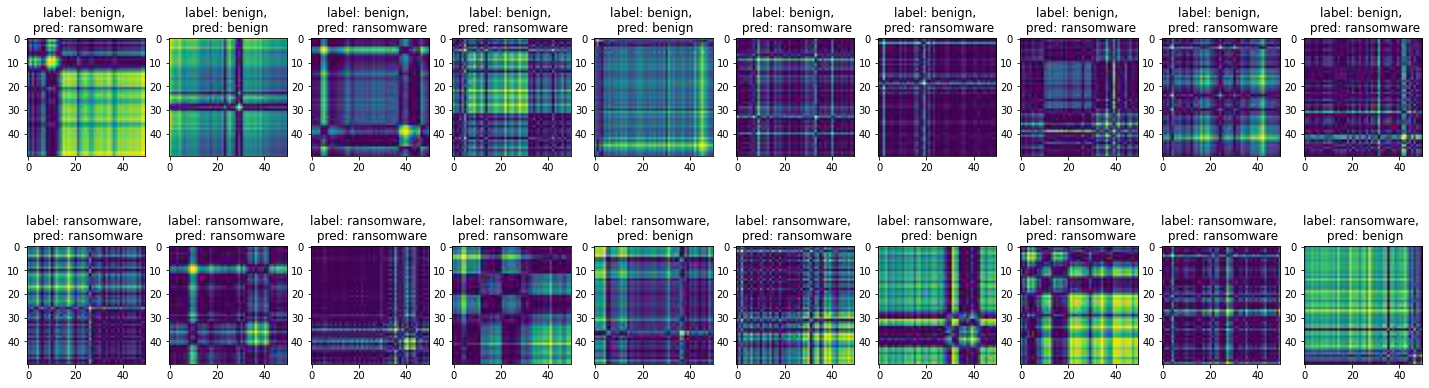

In [202]:
test_gaf_dataloader = DataLoader(test_gaf_dataset, batch_size=1, num_workers=0)
eval_model(test_gaf_dataloader, gaf_idx_to_class, validation_model_gaf)

## Experiment for Markov transition

In [172]:
benign_mtf_path = "features/images/benign/mtf/branch_misses"
ransomware_mtf_path = "features/images/ransomware/mtf/branch_misses"

print("Benign samples", len(glob.glob(os.path.join(benign_mtf_path, "*"))))
print("Ransomware samples", len(glob.glob(os.path.join(ransomware_mtf_path, "*"))))

Benign samples 1432
Ransomware samples 1432


In [173]:
train_mtf_image_paths, valid_mtf_image_paths, test_mtf_image_paths, mtf_idx_to_class, mtf_class_to_idx = create_path_datasets(benign_mtf_path, ransomware_mtf_path)

train_mtf_dataset = RansomwareDetectionDataset(train_mtf_image_paths, mtf_class_to_idx, transform=train_transformations)
validation_mtf_dataset = RansomwareDetectionDataset(valid_mtf_image_paths, mtf_class_to_idx, transform=validation_transformations)
test_mtf_dataset = RansomwareDetectionDataset(test_mtf_image_paths, mtf_class_to_idx, transform=test_transformation)

print(f"Tensor shape of the image: {train_mtf_dataset[1][0].shape}")
print(f"Label of the image: {mtf_idx_to_class[train_mtf_dataset[1][1]]}")

Test dataset len: 20
Train validation dataset len: 2844
Path example: features/images/benign/mtf/branch_misses/benign_1022.jpg
Class example: ransomware
Train size: 1990
Valid size 854
Tensor shape of the image: torch.Size([3, 50, 50])
Label of the image: ransomware


In [174]:
train_mtf_loader, validation_mtf_loader = create_dataloaders(train_mtf_dataset, validation_mtf_dataset, batch_size=30)

Train dataloader shape torch.Size([30, 3, 50, 50])
Validation dataloader shape torch.Size([30, 3, 50, 50])


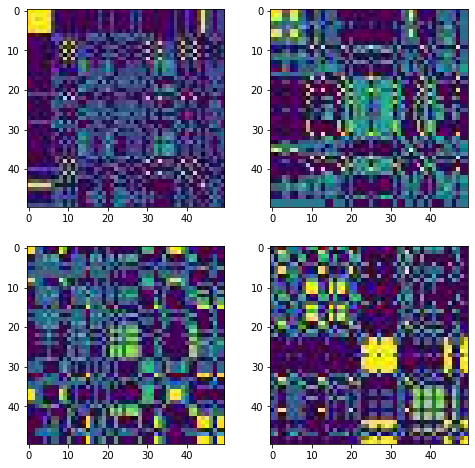

In [138]:
visualize_data_loader(train_mtf_loader, validation_mtf_loader)

In [175]:
mtf_model = BaselineNetwork(number_of_classes=len(mtf_idx_to_class), image_size=50)

In [176]:
checkpoint_callback_mtf = pl.callbacks.ModelCheckpoint(
    dirpath="checkpoints/BM-MTF",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="Loss/valid",
    mode="min"
)
logger_mtf = pl_loggers.TensorBoardLogger("logs/", name="BM-MTF")

trainer_mtf = pl.Trainer(max_epochs=10, log_every_n_steps=1, logger=logger_mtf, callbacks=[checkpoint_callback_mtf])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [177]:
trainer_mtf.fit(mtf_model, train_dataloaders=train_mtf_loader, val_dataloaders=validation_mtf_loader)


  | Name    | Type             | Params
---------------------------------------------
0 | conv1   | Conv2d           | 168   
1 | conv2   | Conv2d           | 660   
2 | maxpool | MaxPool2d        | 0     
3 | dropout | Dropout          | 0     
4 | linear1 | Linear           | 960 K 
5 | linear2 | Linear           | 8.3 K 
6 | linear3 | Linear           | 130   
7 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
969 K     Trainable params
0         Non-trainable params
969 K     Total params
3.877     Total estimated model params size (MB)
/opt/anaconda3/envs/unibern-pytorch/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/BM-MTF exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/anaconda3/envs/unibern-pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/opt/anaconda3/envs/unibern-pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 96/96 [00:13<00:00,  7.22it/s, loss=0.691, v_num=4, Loss/valid=0.692, Accuracy/valid=0.522, Loss/train=0.697, Accuracy/train=0.492]

Epoch 0, global step 66: Loss/valid reached 0.69206 (best 0.69206), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/BM-MTF/best-checkpoint-v1.ckpt" as top 1


Epoch 1: 100%|██████████| 96/96 [00:11<00:00,  8.04it/s, loss=0.694, v_num=4, Loss/valid=0.693, Accuracy/valid=0.503, Loss/train=0.694, Accuracy/train=0.494]

Epoch 1, global step 133: Loss/valid was not in top 1


Epoch 2: 100%|██████████| 96/96 [00:07<00:00, 12.13it/s, loss=0.695, v_num=4, Loss/valid=0.694, Accuracy/valid=0.481, Loss/train=0.694, Accuracy/train=0.493]

Epoch 2, global step 200: Loss/valid was not in top 1


Epoch 3: 100%|██████████| 96/96 [00:07<00:00, 13.01it/s, loss=0.694, v_num=4, Loss/valid=0.693, Accuracy/valid=0.497, Loss/train=0.693, Accuracy/train=0.498]

Epoch 3, global step 267: Loss/valid was not in top 1


Epoch 4: 100%|██████████| 96/96 [00:06<00:00, 14.01it/s, loss=0.691, v_num=4, Loss/valid=0.693, Accuracy/valid=0.497, Loss/train=0.692, Accuracy/train=0.521]

Epoch 4, global step 334: Loss/valid was not in top 1


Epoch 5: 100%|██████████| 96/96 [00:06<00:00, 14.13it/s, loss=0.694, v_num=4, Loss/valid=0.693, Accuracy/valid=0.529, Loss/train=0.693, Accuracy/train=0.513]

Epoch 5, global step 401: Loss/valid was not in top 1


Epoch 6: 100%|██████████| 96/96 [00:06<00:00, 13.76it/s, loss=0.693, v_num=4, Loss/valid=0.693, Accuracy/valid=0.522, Loss/train=0.693, Accuracy/train=0.520]

Epoch 6, global step 468: Loss/valid was not in top 1


Epoch 7: 100%|██████████| 96/96 [00:06<00:00, 14.29it/s, loss=0.694, v_num=4, Loss/valid=0.693, Accuracy/valid=0.508, Loss/train=0.692, Accuracy/train=0.504]

Epoch 7, global step 535: Loss/valid was not in top 1


Epoch 8: 100%|██████████| 96/96 [00:06<00:00, 14.52it/s, loss=0.691, v_num=4, Loss/valid=0.693, Accuracy/valid=0.508, Loss/train=0.692, Accuracy/train=0.536]

Epoch 8, global step 602: Loss/valid was not in top 1


Epoch 9: 100%|██████████| 96/96 [00:07<00:00, 13.70it/s, loss=0.691, v_num=4, Loss/valid=0.693, Accuracy/valid=0.499, Loss/train=0.692, Accuracy/train=0.509]

Epoch 9, global step 669: Loss/valid was not in top 1


Epoch 9: 100%|██████████| 96/96 [00:07<00:00, 13.68it/s, loss=0.691, v_num=4, Loss/valid=0.693, Accuracy/valid=0.499, Loss/train=0.692, Accuracy/train=0.509]


In [143]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6012 (pid 25844), started 1 day, 7:44:03 ago. (Use '!kill 25844' to kill it.)

### Verify the model

In [178]:
validation_model_mtf = BaselineNetwork(number_of_classes=len(mtf_idx_to_class), image_size=50)
checkpoint_mtf = torch.load("checkpoints/BM-MTF/best-checkpoint.ckpt")

validation_model_mtf.load_state_dict(checkpoint_mtf["state_dict"])
validation_model_mtf.eval()

BaselineNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=7500, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=2, bias=True)
  (loss): CrossEntropyLoss()
)

              precision    recall  f1-score   support

      benign       0.67      0.80      0.73        10
  ransomware       0.75      0.60      0.67        10

    accuracy                           0.70        20
   macro avg       0.71      0.70      0.70        20
weighted avg       0.71      0.70      0.70        20



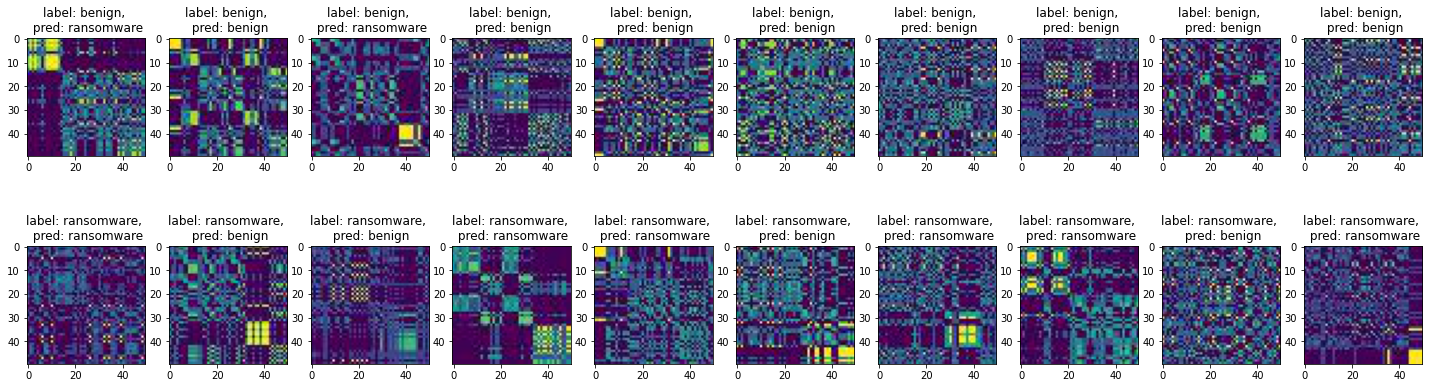

In [179]:
test_mtf_dataloader = DataLoader(test_mtf_dataset, batch_size=1, num_workers=0)
eval_model(test_mtf_dataloader, mtf_idx_to_class, validation_model_mtf)